# Weight Decay Regularization

This notebook explores weight decay regularization in the form of a two-layer MLP being
trained on the MNIST dataset. Both train and test error are evaluated in the context of
no regularization, L2 regularization, and L1 regularization.

## Implementation

Generally speaking, regularizing a loss function via weight decay has the following form:

 $$\hat J(\sigma; X, y) = J(\sigma, X, y) + \alpha \Omega(\sigma) $$

 For loss function **J** and regularizer **Ω**. Assuming **w** represent the weights we wish to parameterize, L2 and L1 regularization have following forms:


#### L2:

$$\Omega(w) = \|w \|_2 = \frac{\alpha}{2} w^Tw$$

#### L1:

$$\Omega(w) = \|w \|_1 = \alpha \sum_i |w_i|$$

In `PyTorch`, generally speakign L2 regularization is performed by setting the `weight_decay` variable for your given optimizer. This is done in the `L2WeightDecayMnistMLP` initializer:

```python
class L2WeightDecayMnistMLP(MnistMLP):
    def __init__(self, rate=1e-3, h1_size=784, h2_size=392, weight_decay=0.01):
        super().__init__(rate, h1_size, h2_size)
        self.optimizer = torch.optim.SGD(
            self.parameters(), lr=rate, weight_decay=weight_decay
        )
        self.weight_decay = weight_decay
```

However, L1 regularization is not supported out of the box. Additionally, without looking into the source code, it's likely (as seen below) weight decay is being applied to bias parameters **as well as** the interaction weights. This is generally undesirable, as bias weights have little chance to overfit but can can result in underfitting if stringent regularization is applied. Therefore, L1 __and__ L2 weight decay were additionally implemented in the `__calculate_loss()` function of the `RegularizedMnistMLP` class:


```python
def __calculate_loss(self, y_pred, y):
    unweighed_loss = super().__calculate_loss(y_pred, y)
    # don't penalize bias parameters per p. 223 of Goodfellow et al.
    weight_norm = sum(
        torch.linalg.norm(p, self.norm)
        for (name, p) in self.named_parameters()
        if "bias" not in name
    )
    return unweighed_loss + self.weight_decay * weight_norm
```
## Set Up

In [1]:
import torch
from torch.utils.data import DataLoader
from sklearn import metrics
import numpy as np

from nets import *

train_mnist = get_mnist(train=True)
test_mnist = get_mnist(train = False)

## Helper Functions

1. `get_fit_model()`
    - Train our models for 50 epochs or load previously saved models if the same model has already been trained. Fewer epochs were chosen to highlight differences between approaches.
2. `evaluate_model()`
    - Evaluate model on a provided data split using the Matthew's Correlation Coefficient and calculated loss.

In [2]:
def get_fit_model(model, model_name, data_loader, force_train = False):
    save_path = pathlib.Path("trained_models").joinpath(f"{model_name}.pt")
    if not save_path.exists() or force_train:
        print(f"No model found at {str(save_path)}. Fitting...")
        model.to(model.get_device())
        model.fit(data_loader, n_epochs=50, verbose=True, verbose_step=10, track_loss=True)
        print(f"Model fit, saving weights to {str(save_path)}.")
        torch.save(model, save_path)
    else:
        print("Previously trained model discovered, loading model.")
        model = torch.load(save_path)
    return model

In [3]:
def evaluate_model(model, data_loader, split):
    mccs = np.zeros(len(data_loader))
    loss = np.zeros(len(data_loader))
    model.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(data_loader):
            y_hat = model(X.to(model.get_device()))
            y_pred = y_hat.argmax(axis=1)
            loss[i] = model.loss(y_hat, y.to(model.get_device())).cpu().item()
            mccs[i] = metrics.matthews_corrcoef(y.cpu(), y_pred.cpu())
    print(f"Mean {split} MCC {mccs.mean():0.2f}, Mean loss: {loss.mean():0.7f}")
    return(mccs, loss)


## Full Model Training

In [4]:
full_model = MnistMLP(rate=0.01)
print(full_model)

MnistMLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=392, bias=True)
    (3): ReLU()
    (4): Linear(in_features=392, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
)


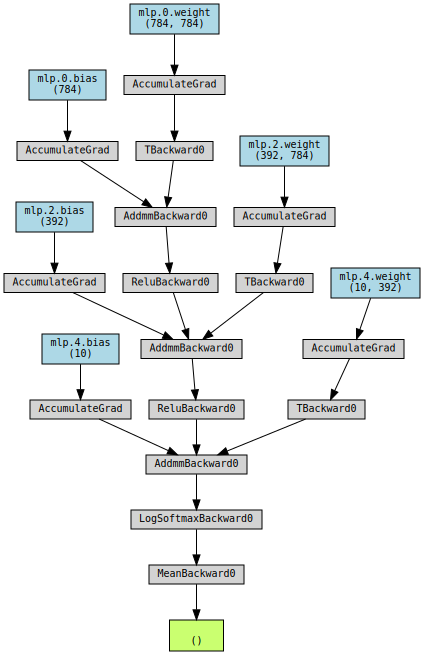

In [5]:
full_model.draw_network()

In [6]:
training_data = DataLoader(train_mnist, batch_size=64, shuffle=True)

In [7]:
full_model = get_fit_model(full_model, "full_model", training_data, force_train=False)

No model found at trained_models\full_model.pt. Fitting...
Loss: 1.501318 [    1/   50]
Loss: 0.208726 [   10/   50]
Loss: 0.121589 [   20/   50]
Loss: 0.079487 [   30/   50]
Loss: 0.054551 [   40/   50]
Loss: 0.039228 [   50/   50]
Model fit, saving weights to trained_models\full_model.pt.


In [8]:
full_model_train_results = evaluate_model(full_model, training_data, "train")

Mean train MCC 0.99, Mean loss: 0.0373971


In [9]:
test_data = DataLoader(test_mnist, batch_size=64, shuffle=True)
full_model_test_results = evaluate_model(full_model, test_data, "test")

Mean test MCC 0.98, Mean loss: 0.0712454


## L2 Regularized Model - Weight Decay

In [10]:
weight_decay_model = L2WeightDecayMnistMLP(rate=0.01)
print(weight_decay_model)

L2WeightDecayMnistMLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=392, bias=True)
    (3): ReLU()
    (4): Linear(in_features=392, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
)


In [11]:
weight_decay_model = get_fit_model(weight_decay_model, "weight_decay_model", training_data, force_train=False)

No model found at trained_models\weight_decay_model.pt. Fitting...
Loss: 1.601467 [    1/   50]
Loss: 0.296922 [   10/   50]
Loss: 0.248246 [   20/   50]
Loss: 0.227912 [   30/   50]
Loss: 0.217188 [   40/   50]
Loss: 0.210951 [   50/   50]
Model fit, saving weights to trained_models\weight_decay_model.pt.


In [12]:
weight_decay_model_train_results = evaluate_model(weight_decay_model, training_data, "train")

Mean train MCC 0.94, Mean loss: 0.2095855


In [13]:
weight_decay_model_test_results = evaluate_model(weight_decay_model, test_data, "test")

Mean test MCC 0.94, Mean loss: 0.2042432


## L2 Regularization - Only Weights

In [14]:

l2_model = RegularizedMnistMLP(norm = 2, rate=0.01)
print(l2_model)

RegularizedMnistMLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=392, bias=True)
    (3): ReLU()
    (4): Linear(in_features=392, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
)


In [15]:
l2_model = get_fit_model(l2_model, "l2_model", training_data, force_train=False)

No model found at trained_models\l2_model.pt. Fitting...
Loss: 1.550503 [    1/   50]
Loss: 0.204988 [   10/   50]
Loss: 0.120447 [   20/   50]
Loss: 0.078865 [   30/   50]
Loss: 0.055032 [   40/   50]
Loss: 0.039483 [   50/   50]
Model fit, saving weights to trained_models\l2_model.pt.


In [16]:
l2_model_train_results = evaluate_model(l2_model, training_data, "train")

Mean train MCC 0.99, Mean loss: 0.0376031


In [17]:
l2_model_test_results = evaluate_model(l2_model, test_data, "test")

Mean test MCC 0.98, Mean loss: 0.0691480


## L1 Regularization

In [18]:

l1_model = RegularizedMnistMLP(norm=1, rate=0.01)
print(l1_model)

RegularizedMnistMLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=392, bias=True)
    (3): ReLU()
    (4): Linear(in_features=392, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
)


In [19]:
l1_model = get_fit_model(l1_model, "l1_model", training_data, force_train=False)

No model found at trained_models\l1_model.pt. Fitting...
Loss: 1.528984 [    1/   50]
Loss: 0.209676 [   10/   50]
Loss: 0.122454 [   20/   50]
Loss: 0.080041 [   30/   50]
Loss: 0.055337 [   40/   50]
Loss: 0.039831 [   50/   50]
Model fit, saving weights to trained_models\l1_model.pt.


In [20]:
l1_model_train_results = evaluate_model(l1_model, training_data, "train")

Mean train MCC 0.99, Mean loss: 0.0376188


In [21]:
l1_model_test_results = evaluate_model(l1_model, test_data, "test")

Mean test MCC 0.98, Mean loss: 0.0713448


## Results

We see from the printed results, that the full model along with the L1 + L2 **weight** regularized models achieve similar test results, with L2 performing the best with MCC=0.99. Likewise, we see L2 weight decay set via `SGD` results in an underfit model -- possibly due to regularization of biases. These results are explored graphically below. 

In [24]:
import pandas as pd
import seaborn as sns

dfs = []
for model, name in zip([full_model, weight_decay_model, l2_model, l1_model],
                       ["full", "weight decay", "L2", "L1"]):
    dfs.append(
        pd.DataFrame(
            {'mean_loss': model.mean_loss_, 'loss_std': model.std_loss_, "epoch": model.epochs_,"model": name}
        )
    )

In [25]:
training_df = pd.concat(dfs)
training_df.head()

,mean_loss,loss_std,epoch,model
0,1.501318,0.596629,0,full
1,0.208726,0.084429,9,full
2,0.121589,0.062131,19,full
3,0.079487,0.049735,29,full
4,0.054551,0.038203,39,full


Text(0.0, 1.0, 'Loss during training')

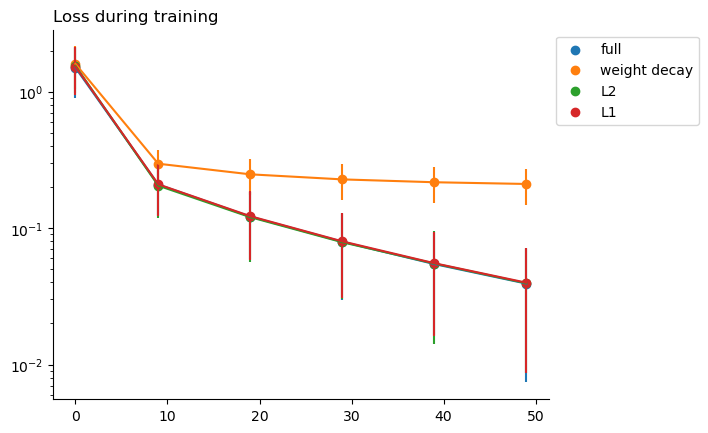

In [52]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
for each in training_df.model.unique():
    subset = training_df.query("model == @each")
    ax.scatter(subset.epoch, subset.mean_loss, label=each)
    ax.errorbar(subset.epoch, subset.mean_loss, yerr=subset.loss_std)
ax.set_yscale('log')
ax.spines[['top', 'right']].set_visible(False)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title("Loss during training", loc='left')


In [82]:
dfs = []
results = {
    "train": {
        "full": full_model_train_results,
        "decay": weight_decay_model_train_results,
        "L2": l2_model_train_results,
        "L1": l1_model_train_results
    },
    "test":  {
        "full": full_model_test_results,
        "decay": weight_decay_model_test_results,
        "L2": l2_model_test_results,
        "L1": l1_model_test_results
    }
}
for split, data in results.items():
    for key, res in data.items():
        dfs.append(
            pd.DataFrame(
                {"MCC": res[0], "Loss": res[1], "Model": key, "Split": split}
            )
        )

In [83]:
results_df = pd.concat(dfs).melt(id_vars = ['Model', 'Split'])
results_df.head()

,Model,Split,variable,value
0,full,train,MCC,0.964807
1,full,train,MCC,1.000000
2,full,train,MCC,0.982659
3,full,train,MCC,1.000000
4,full,train,MCC,0.982774


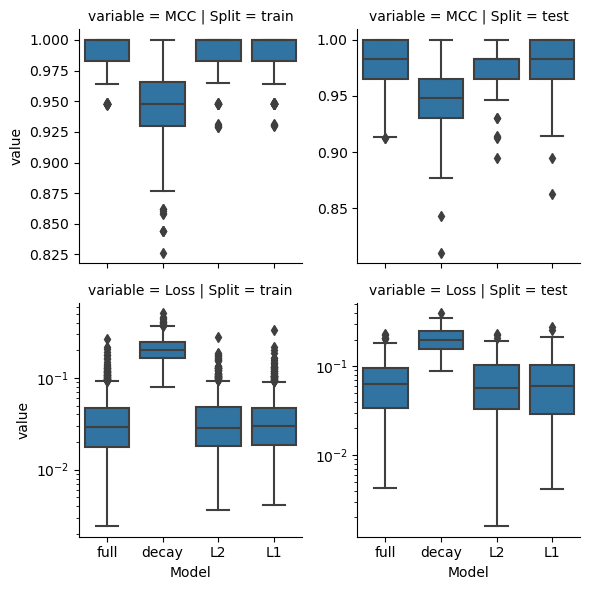

In [84]:
g = sns.FacetGrid(results_df, row = "variable", col="Split", sharey=False)
g.map_dataframe(sns.boxplot, x="Model", y="value")
for ax in g.axes[1, :]:
    ax.set_yscale('log')